# When do the hands of the clock face each other?
At which times are the hour and the minute hand of the clock located exaclty opposite of each other?

This notebook shows two approaches to determine these times using python:
 - the analytical solution using sympy
 - numeric optimization using scipy.optimize

## Exact Solution using SymPy
Let $\varphi_h$ be the angle of the hour hand. Then the position of the minute hand ist described be the angle 

$\varphi_m = 12 \varphi_h$.

The position opposite of the hour hand can be describes as

$\varphi_{ho} = \varphi_h + \pi$.

The hands are located opposite to each other whenever the position of the hour hand $\varphi_{ho}$ plus any multiples of $2 \pi$ is equal to the position of the minute hand:

$\varphi_{ho} + n 2 \pi = \varphi_m$.

The connection between the time $h$ in hours and the position of the hour hand ist as follows:

$h = (12 \varphi_h) / (2\pi)$.



In [1]:
from sympy import *
init_printing()
phi_h, phi_ho, phi_m, n, h = symbols('phi_h, phi_ho, phi_m, n, h')

In [2]:
eq = [Eq(phi_m, 12*phi_h),
      Eq(phi_ho, phi_h + pi),
      Eq(phi_ho + n*2*pi, phi_m),
      Eq(h, phi_h*12/2/pi)]
print('Set of equations:')
pprint(eq)
sol = linsolve(eq, h, phi_h , phi_ho, phi_m)
print('Solution:')
pprint(list(sol))
h_sol = list(sol)[0][0]

Set of equations:
⎡                                                6⋅φₕ⎤
⎢φₘ = 12⋅φₕ, φₕₒ = φₕ + π, 2⋅π⋅n + φₕₒ = φₘ, h = ────⎥
⎣                                                 π  ⎦
Solution:
⎡⎛12⋅n   6   π⋅(2⋅n + 1)  2⋅π⋅(n + 6)  12⋅π⋅(2⋅n + 1)⎞⎤
⎢⎜──── + ──, ───────────, ───────────, ──────────────⎟⎥
⎣⎝ 11    11       11           11            11      ⎠⎦


The solution for all times is the following for all n:

In [3]:
pprint(h_sol)

12⋅n   6 
──── + ──
 11    11


This equation is evaluated for $n \in [0, 11]$, float-values with 20 digits are calculated and the results are transformed into hours, minutes and seconds:

In [4]:
import numpy as np
for val in range(11):
    hS = (h_sol).subs(n, val).n(20)
    print('h = {org:015.12f} is {h:02.0f}:{m:02.0f}\'{s:08.5f}"'.format(
        org=float(hS),
        h=float(np.floor(hS)),
        m=float(np.floor(np.mod(hS, 1.0)*60)),
        s=float(np.mod((np.mod(hS, 1.0)*60), 1.0)*60)))

h = 00.545454545455 is 00:32'43.63636"
h = 01.636363636364 is 01:38'10.90909"
h = 02.727272727273 is 02:43'38.18182"
h = 03.818181818182 is 03:49'05.45455"
h = 04.909090909091 is 04:54'32.72727"
h = 06.000000000000 is 06:00'00.00000"
h = 07.090909090909 is 07:05'27.27273"
h = 08.181818181818 is 08:10'54.54545"
h = 09.272727272727 is 09:16'21.81818"
h = 10.363636363636 is 10:21'49.09091"
h = 11.454545454545 is 11:27'16.36364"


In [5]:
# Imports
%matplotlib inline
from pylab import *
from scipy.optimize import fmin
rcParams['figure.figsize'] = [9.0, 6.0]

## Positionen der Zeiger
### Stundenzeiger
Der Winkel $\varphi$ beschreibt die Position des Stundenzeigers.
### Minutenzeiger
Die Position des Minutenzeigers $\varphi_m$ ist abhängig von $\varphi$: Bei einer Drehung des Stundenzeigers, dreht er sich 12 mal im Kreis:

$ \phi_m = \phi * 12 $.

Durch Modulorechnung mit $2 \pi$ wird ein Winkel $< 2 \pi$ bestimmt:


In [6]:
phim = lambda phi: np.mod(phi*12.0, 2*np.pi)

### Gegenüberliegende Richtung
Die einem Zeiger gegenüberliegende Winkelposition wird durch Verdrehen um $\pi$ und eine erneute Modulorechnung bestimmt:

In [7]:
gegenueber = lambda p: np.mod(p+np.pi, 2*np.pi)

## Grob bestimmte Zeitpunkte

Zur Bestimmung der ungefähren Zeitpunkte werden die Zeigerpositionen für 500 Zeitpunkte ausgewertet:

In [8]:
phi = np.linspace(-0.1, 2*np.pi+0.1, 500)

Die interessierenden Zeitpunkte sind die, bei denen die Stundenzeigerposition gleich der dem 
Minutenzeiger gegeüberliegenden ist:

$\varphi$ == gegenueber($\varphi_m$).

Es weden die Indices des Vektors *phi* gesucht, bei denen sich die beiden Funktionswerte schneiden, d.h. die Indices $i$ bei denen 

$phi_i >= gegenueber(phim_i)$

ist und

$phi_{i+1} < gegenueber(phim_{i+1})$.

In [9]:
idc = np.where((phi[:-1]>=gegenueber(phim(phi[:-1])))*
               (phi[1:]<gegenueber(phim(phi[1:]))))[0]
print('Stundenzeigerpositionen: ', phi[idc])

Stundenzeigerpositionen:  [ 0.2767783   0.84844194  1.42010557  1.99176921  2.56343284  3.13509648
  3.70676011  4.27842374  4.85008738  5.42175101  5.99341465]


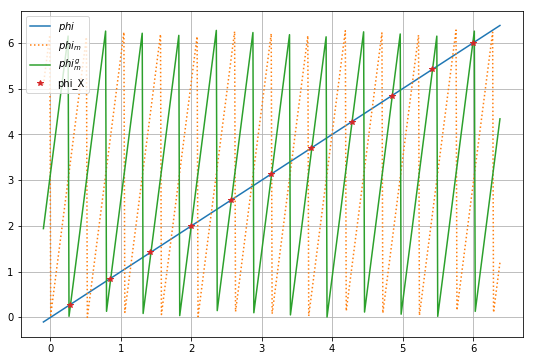

In [10]:
# Dartstellung der Winkelverläufe und der grob bestimmten Schnittpunkte:
plot(phi, phi, label='$phi$')
plot(phi, phim(phi), ':', label='$phi_m$')
plot(phi, gegenueber(phim(phi)), label='$phi_m^g$')
plot(phi[idc], phi[idc], '*', label='phi_X')
legend()
grid(True)

## Numerische Optimierung: Bestimmung der Schnittpunkte 

In [11]:
fun = lambda p: (p-gegenueber(phim(p)))**2

phi_X = [fmin(fun, np.array([phi[i]]), disp=False, ftol=1e-12)[0]
         for i in idc]

print(phi[idc]-phi_X)

[-0.008821   -0.00835612 -0.00789107 -0.00742609 -0.0069611  -0.00649615
 -0.00603114 -0.00556542 -0.00510124 -0.00463633 -0.00417129]


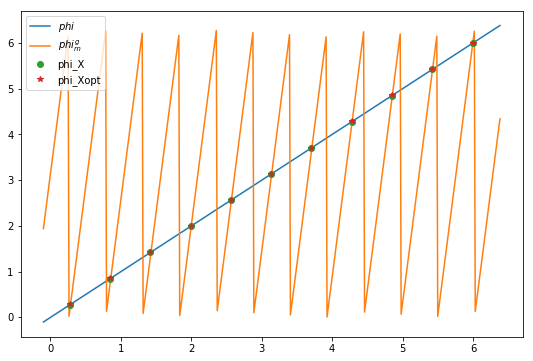

In [12]:
plot(phi, phi, label='$phi$')
plot(phi, gegenueber(phim(phi)), label='$phi_m^g$')
plot(phi[idc], phi[idc], 'o', label='phi_X')
plot(phi[idc], phi_X, '*', label='phi_Xopt')
legend()


In [13]:
for p in phi_X:
    hf = p/2/np.pi*12
    h = int(hf)
    m = int((hf-h)*60)
    s = (hf-h-m/60)*60*60
    print('{h:02d}:{m:02d}\'{s:2.4f}'.format(h=h, m=m, s=s))

00:32'43.6362
01:38'10.9095
02:43'38.1817
03:49'5.4544
04:54'32.7270
05:59'59.9998
07:05'27.2722
08:10'54.5399
09:16'21.8180
10:21'49.0912
11:27'16.3634


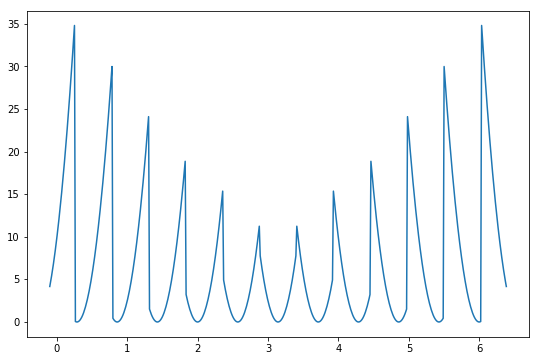

In [14]:
# Gütefunktion:
plot(phi, fun(phi))

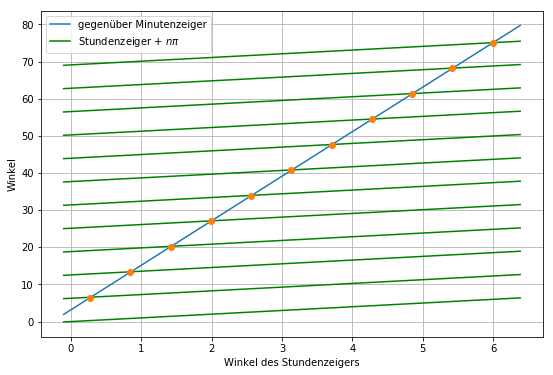

In [15]:
plot(phi, phi*12+np.pi, label='$phi_{gegenüber}$')
for offs in range(12):
    plot(phi, phi+offs*2*np.pi, 'g', label='$phi$')
plot(phi[idc], phi[idc]*12+np.pi, 'o', label='phi_Xopt')
legend(('gegenüber Minutenzeiger', 'Stundenzeiger + $n\pi$'))
xlabel('Winkel des Stundenzeigers')
ylabel('Winkel')
grid(True)

# Symbolisch: Einfacher?

In [16]:
from sympy import *
init_printing()
phi, phim, n, h = symbols('varphi, varphi_m, n, h')

$ h = phi/{2\pi} *12$

$\varphi == gegenueber(\varphi_m) - n * 2\pi$

$\varphi == 12 \varphi + \pi - n 2\pi$

$\varphi - 12 \varphi - \pi + n  2\pi == 0$


In [17]:
phi = h/12 * 2 * pi
phim = 12 * phi
eq = phi + n*2*pi-phim+pi
pprint(eq)
h_eq = solve(eq, h)[0]
h_eq

  11⋅π⋅h            
- ────── + 2⋅π⋅n + π
    6               


In [18]:
for val in range(1, 12):
    hS = (h_eq).subs(n, val).n(20)
    print('{org:015.12f}: {h:02.0f}:{m:02.0f}\'{s:08.5f}"'.format(
        org=float(hS),
        h=float(np.floor(hS)),
        m=float(np.floor(np.mod(hS, 1.0)*60)),
        s=float(np.mod((np.mod(hS, 1.0)*60), 1.0)*60)))


01.636363636364: 01:38'10.90909"
02.727272727273: 02:43'38.18182"
03.818181818182: 03:49'05.45455"
04.909090909091: 04:54'32.72727"
06.000000000000: 06:00'00.00000"
07.090909090909: 07:05'27.27273"
08.181818181818: 08:10'54.54545"
09.272727272727: 09:16'21.81818"
10.363636363636: 10:21'49.09091"
11.454545454545: 11:27'16.36364"
12.545454545455: 12:32'43.63636"


## Zeiger in die gleiche Richtung

In [19]:
phi = h/12 * 2 * pi
phim = 12 * phi
eq = phi + n*2*pi - phim 
pprint(eq)
h_eq = solve(eq, h)[0]
h_eq

  11⋅π⋅h        
- ────── + 2⋅π⋅n
    6           


In [20]:
for val in range(1, 12):
    hS = (h_eq).subs(n, val).n(20)
    print('{org:015.12f}: {h:02.0f}:{m:02.0f}\'{s:08.5f}"'.format(
        org=float(hS),
        h=float(np.floor(hS)),
        m=float(np.floor(np.mod(hS, 1.0)*60)),
        s=float(np.mod((np.mod(hS, 1.0)*60), 1.0)*60)))


01.090909090909: 01:05'27.27273"
02.181818181818: 02:10'54.54545"
03.272727272727: 03:16'21.81818"
04.363636363636: 04:21'49.09091"
05.454545454545: 05:27'16.36364"
06.545454545455: 06:32'43.63636"
07.636363636364: 07:38'10.90909"
08.727272727273: 08:43'38.18182"
09.818181818182: 09:49'05.45455"
10.909090909091: 10:54'32.72727"
12.000000000000: 12:00'00.00000"
